In [1]:
OLD_ENV_PATH = %env PATH
%env PATH=/home/bruno-pacheco/ants-2.4.3/bin:/home/bruno-pacheco/ants-2.4.3/lib:$OLD_ENV_PATH

env: PATH=/home/bruno-pacheco/ants-2.4.3/bin:/home/bruno-pacheco/ants-2.4.3/lib:/home/bruno-pacheco/miniconda3/envs/mgmt/bin:/home/bruno-pacheco/.vscode-server/bin/e8a3071ea4344d9d48ef8a4df2c097372b0c5161/bin/remote-cli:/home/bruno-pacheco/fsl/bin:/home/bruno-pacheco/fsl/bin:/home/bruno-pacheco/miniconda3/bin:/home/bruno-pacheco/miniconda3/condabin:/home/bruno-pacheco/fsl/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/home/bruno-pacheco/pkg/CaPTk/1.9.0/squashfs-root/usr/bin:/home/bruno-pacheco/pkg/CaPTk/1.9.0/squashfs-root/usr/lib:$PATH:/home/bruno-pacheco/.vscode-server/bin/e8a3071ea4344d9d48ef8a4df2c097372b0c5161/bin/remote-cli:/home/bruno-pacheco/fsl/bin:/home/bruno-pacheco/fsl/bin:/home/bruno-pacheco/miniconda3/bin:/home/bruno-pacheco/miniconda3/condabin:/home/bruno-pacheco/fsl/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pandas as pd
from pathlib import Path
import nibabel as nib
from brats.utils import dcm2nifti, show_mri
from tqdm.notebook import tqdm

from shutil import copy

from brats.preprocessing.preprocessing import PreprocessorHDBET


def dcm_bad_dir_to_nifti(dcm_dir, tmp_dcm_dir='.tmpdir/tmp_dcm'):
    tmp_dcm_dir = Path(tmp_dcm_dir)

    # clean tmp dir
    for f in tmp_dcm_dir.glob('*.dcm'):
        f.unlink()

    for f in Path(dcm_dir).glob('*.dcm'):
        (tmp_dcm_dir/f.name).symlink_to(f)
    
    print(tmp_dcm_dir)
        
    return dcm2nifti(tmp_dcm_dir, '.tmpdir')

/home/bruno-pacheco/miniconda3/envs/mgmt/lib/python3.11/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
df_t1 = pd.read_csv('../T1_DCMs.csv')
df_t2 = pd.read_csv('../T2_DCMs.csv')

In [5]:
from subprocess import CalledProcessError

prep = PreprocessorHDBET(
    template_fpath='../data/SRI24_T1_brain.nii',
    tmpdir=Path('.tmpdir'),
    bet_modality='T1',
    mode='fast',
    n4='after',
)

tmp_dcm_dir='.tmpdir/tmp_dcm'
Path(tmp_dcm_dir).mkdir(exist_ok=True)

target_dir = Path('../data/PrepIMGs')
target_dir.mkdir(exist_ok=True)

sid_disaligned = list()
multiple_t1 = list()
multiple_t2 = list()

doesnt_exist_t1 = list()
doesnt_exist_t2 = list()

gen_error = list()
for t1_s, t2_s in list(zip(df_t1.sort_values(by='Subject ID').iloc, df_t2.sort_values(by='Subject ID').iloc)):
    target_t1_fpath = target_dir/(t1_s['Subject ID'] + '_T1.nii')
    target_t2_fpath = target_dir/(t1_s['Subject ID'] + '_T2.nii')

#     if t1_s['Subject ID'] == 'TCGA-76-4925':
#         continue

    if target_t1_fpath.exists():
        target_t1_fpath.unlink()

    if target_t2_fpath.exists():
        target_t2_fpath.unlink()
#     if target_t1_fpath.exists() and target_t2_fpath.exists():
#         continue

    if t1_s['Subject ID'] != t2_s['Subject ID']:
        print(f"Problem at id {t1_s.name}")
        sid_disaligned.append(t1_s.name)
        continue

    skip = False
    try:
        t1_dcm_dir = next(Path('../data/TCGA').glob(f"**/*{t1_s['Image ID']}/*.dcm")).parent
    except StopIteration:
        doesnt_exist_t1.append(t1_s['Subject ID'])
        skip = True

    try:
        t2_dcm_dir = next(Path('../data/TCGA').glob(f"**/*{t2_s['Image ID']}/*.dcm")).parent
    except StopIteration:
        doesnt_exist_t2.append(t2_s['Subject ID'])
        skip = True

    if skip:
        continue

    # t1_fpath = dcm_bad_dir_to_nifti(t1_dcm_dir)
    # t2_fpath = dcm_bad_dir_to_nifti(t2_dcm_dir)
    t1_fpath = dcm2nifti(t1_dcm_dir, '.tmpdir')
    t2_fpath = dcm2nifti(t2_dcm_dir, '.tmpdir')

    if isinstance(t1_fpath, list) and isinstance(t2_fpath, list):
        for i in range(len(t1_fpath)):
            t1_fpath_ = t1_fpath[i]
            for j in range(len(t2_fpath)):
                t2_fpath_ = t2_fpath[j]
                
                try:
                    r = prep.run(t1_fpath=t1_fpath_, t2_fpath=t2_fpath_)[0]
                except CalledProcessError:
                    gen_error.append(t1_s['Subject ID'])
                    continue
                
                nib.save(r['t1'], str(target_t1_fpath).replace('T1', f'T1_{i}'))
                nib.save(r['t2'], str(target_t2_fpath).replace('T2', f'T2_{i}'))
    elif isinstance(t1_fpath, list):
        for i in range(len(t1_fpath)):
            t1_fpath_ = t1_fpath[i]

            try:
                r = prep.run(t1_fpath=t1_fpath_, t2_fpath=t2_fpath)[0]
            except CalledProcessError:
                gen_error.append(t1_s['Subject ID'])
                continue

            nib.save(r['t1'], str(target_t1_fpath).replace('T1', f'T1_{i}'))
            nib.save(r['t2'], target_t2_fpath)
    elif isinstance(t2_fpath, list):
        for i in range(len(t2_fpath)):
            t2_fpath_ = t2_fpath[i]

            try:
                r = prep.run(t1_fpath=t1_fpath, t2_fpath=t2_fpath_)[0]
            except CalledProcessError:
                gen_error.append(t1_s['Subject ID'])
                continue

            nib.save(r['t1'], target_t1_fpath)
            nib.save(r['t2'], str(target_t2_fpath).replace('T2', f'T2_{i}'))
    else:
        try:
            r = prep.run(t1_fpath=t1_fpath, t2_fpath=t2_fpath)[0]
        except CalledProcessError:
            gen_error.append(t1_s['Subject ID'])
            continue

        nib.save(r['t1'], target_t1_fpath)
        nib.save(r['t2'], target_t2_fpath)
    break

230109-23:06:27,378 nipype.interface INFO:
	 stdout 2023-01-09T23:06:27.378165:Chris Rorden's dcm2niiX version v1.0.20200331  (JP2:OpenJPEG) (JP-LS:CharLS) GCC5.5.0 (64-bit Linux)
230109-23:06:27,378 nipype.interface INFO:
	 stdout 2023-01-09T23:06:27.378165:Found 25 DICOM file(s)
230109-23:06:27,379 nipype.interface INFO:
	 stdout 2023-01-09T23:06:27.378165:Convert 25 DICOM as .tmpdir/12.000000-AX_T1-90444_AX_T1_19970608090647_12b (256x256x25x1)
230109-23:06:27,425 nipype.interface INFO:
	 stdout 2023-01-09T23:06:27.425104:Compress: "/usr/bin/pigz" -b 960 -n -f -6 ".tmpdir/12.000000-AX_T1-90444_AX_T1_19970608090647_12b.nii"
230109-23:06:27,425 nipype.interface INFO:
	 stdout 2023-01-09T23:06:27.425104:Conversion required 0.055256 seconds (0.009894 for core code).
230109-23:06:27,502 nipype.interface INFO:
	 stdout 2023-01-09T23:06:27.502014:Chris Rorden's dcm2niiX version v1.0.20200331  (JP2:OpenJPEG) (JP-LS:CharLS) GCC5.5.0 (64-bit Linux)
230109-23:06:27,502 nipype.interface INFO:
	 

Traceback (most recent call last):
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/bin/hd-bet", line 7, in <module>
    exec(compile(f.read(), __file__, 'exec'))
  File "/home/bruno-pacheco/HD-BET/HD_BET/hd-bet", line 121, in <module>
    run_hd_bet(input_files, output_files, mode, config_file, device, pp, tta, save_mask, overwrite_existing)
  File "/home/bruno-pacheco/HD-BET/HD_BET/run.py", line 63, in run_hd_bet
    net.cuda(device)
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/lib/python3.11/site-packages/torch/nn/modules/module.py", line 747, in cuda
    return self._apply(lambda t: t.cuda(device))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/lib/python3.11/site-packages/torch/nn/modules/module.py", line 639, in _apply
    module._apply(fn)
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/lib/python3.11/site-packages/torch/nn/modules/module.py", line 662, in _apply
    param_applied = fn(param)
                    ^^^^^^^^^
 

230109-23:06:32,238 nipype.interface INFO:
	 stdout 2023-01-09T23:06:32.238810:Compress: "/usr/bin/pigz" -b 960 -n -f -6 ".tmpdir/5.000000-AX_T1-62419_AX_T1_19960823093955_5a.nii"
230109-23:06:32,239 nipype.interface INFO:
	 stdout 2023-01-09T23:06:32.238810:Conversion required 0.058458 seconds (0.008308 for core code).
230109-23:06:32,311 nipype.interface INFO:
	 stdout 2023-01-09T23:06:32.311472:Chris Rorden's dcm2niiX version v1.0.20200331  (JP2:OpenJPEG) (JP-LS:CharLS) GCC5.5.0 (64-bit Linux)
230109-23:06:32,311 nipype.interface INFO:
	 stdout 2023-01-09T23:06:32.311472:Found 23 DICOM file(s)
230109-23:06:32,312 nipype.interface INFO:
	 stdout 2023-01-09T23:06:32.311472:Convert 23 DICOM as .tmpdir/3.000000-AX_T2_FSE-27597_AX_T2_FSE_19960823093955_3a (256x256x23x1)
230109-23:06:32,362 nipype.interface INFO:
	 stdout 2023-01-09T23:06:32.362241:Compress: "/usr/bin/pigz" -b 960 -n -f -6 ".tmpdir/3.000000-AX_T2_FSE-27597_AX_T2_FSE_19960823093955_3a.nii"
230109-23:06:32,362 nipype.interf

Traceback (most recent call last):
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/bin/hd-bet", line 7, in <module>
    exec(compile(f.read(), __file__, 'exec'))
  File "/home/bruno-pacheco/HD-BET/HD_BET/hd-bet", line 121, in <module>
    run_hd_bet(input_files, output_files, mode, config_file, device, pp, tta, save_mask, overwrite_existing)
  File "/home/bruno-pacheco/HD-BET/HD_BET/run.py", line 63, in run_hd_bet
    net.cuda(device)
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/lib/python3.11/site-packages/torch/nn/modules/module.py", line 747, in cuda
    return self._apply(lambda t: t.cuda(device))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/lib/python3.11/site-packages/torch/nn/modules/module.py", line 639, in _apply
    module._apply(fn)
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/lib/python3.11/site-packages/torch/nn/modules/module.py", line 662, in _apply
    param_applied = fn(param)
                    ^^^^^^^^^
 

230109-23:06:37,144 nipype.interface INFO:
	 stdout 2023-01-09T23:06:37.144124:Chris Rorden's dcm2niiX version v1.0.20200331  (JP2:OpenJPEG) (JP-LS:CharLS) GCC5.5.0 (64-bit Linux)
230109-23:06:37,144 nipype.interface INFO:
	 stdout 2023-01-09T23:06:37.144124:Found 23 DICOM file(s)
230109-23:06:37,144 nipype.interface INFO:
	 stdout 2023-01-09T23:06:37.144124:Convert 23 DICOM as .tmpdir/3.000000-AX_T2_FSE-01423_AX_T2_FSE_19970614073837_3a (256x256x23x1)
230109-23:06:37,197 nipype.interface INFO:
	 stdout 2023-01-09T23:06:37.197009:Compress: "/usr/bin/pigz" -b 960 -n -f -6 ".tmpdir/3.000000-AX_T2_FSE-01423_AX_T2_FSE_19970614073837_3a.nii"
230109-23:06:37,197 nipype.interface INFO:
	 stdout 2023-01-09T23:06:37.197009:Conversion required 0.060735 seconds (0.009243 for core code).
antsRegistration --collapse-output-transforms 1 --dimensionality 3 --float 1 --initial-moving-transform [ ../data/SRI24_T1_brain.nii, /home/bruno-pacheco/mgmt-prediction/notebooks/.tmpdir/5.000000-AX_T1-38458_AX_T

Traceback (most recent call last):
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/bin/hd-bet", line 7, in <module>
    exec(compile(f.read(), __file__, 'exec'))
  File "/home/bruno-pacheco/HD-BET/HD_BET/hd-bet", line 121, in <module>
    run_hd_bet(input_files, output_files, mode, config_file, device, pp, tta, save_mask, overwrite_existing)
  File "/home/bruno-pacheco/HD-BET/HD_BET/run.py", line 63, in run_hd_bet
    net.cuda(device)
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/lib/python3.11/site-packages/torch/nn/modules/module.py", line 747, in cuda
    return self._apply(lambda t: t.cuda(device))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/lib/python3.11/site-packages/torch/nn/modules/module.py", line 639, in _apply
    module._apply(fn)
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/lib/python3.11/site-packages/torch/nn/modules/module.py", line 662, in _apply
    param_applied = fn(param)
                    ^^^^^^^^^
 

230109-23:06:40,826 nipype.interface INFO:
	 stdout 2023-01-09T23:06:40.825825:Conversion required 0.063941 seconds (0.009640 for core code).
230109-23:06:40,895 nipype.interface INFO:
	 stdout 2023-01-09T23:06:40.895706:Chris Rorden's dcm2niiX version v1.0.20200331  (JP2:OpenJPEG) (JP-LS:CharLS) GCC5.5.0 (64-bit Linux)
230109-23:06:40,896 nipype.interface INFO:
	 stdout 2023-01-09T23:06:40.895706:Found 23 DICOM file(s)
230109-23:06:40,896 nipype.interface INFO:
	 stdout 2023-01-09T23:06:40.895706:Convert 23 DICOM as .tmpdir/3.000000-AX_T2_FSE-77488_AX_T2_FSE_19980201200904_3a (256x256x23x1)
230109-23:06:40,949 nipype.interface INFO:
	 stdout 2023-01-09T23:06:40.949935:Compress: "/usr/bin/pigz" -b 960 -n -f -6 ".tmpdir/3.000000-AX_T2_FSE-77488_AX_T2_FSE_19980201200904_3a.nii"
230109-23:06:40,950 nipype.interface INFO:
	 stdout 2023-01-09T23:06:40.949935:Conversion required 0.061467 seconds (0.008727 for core code).
antsRegistration --collapse-output-transforms 1 --dimensionality 3 --fl

Traceback (most recent call last):
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/bin/hd-bet", line 7, in <module>
    exec(compile(f.read(), __file__, 'exec'))
  File "/home/bruno-pacheco/HD-BET/HD_BET/hd-bet", line 121, in <module>
    run_hd_bet(input_files, output_files, mode, config_file, device, pp, tta, save_mask, overwrite_existing)
  File "/home/bruno-pacheco/HD-BET/HD_BET/run.py", line 63, in run_hd_bet
    net.cuda(device)
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/lib/python3.11/site-packages/torch/nn/modules/module.py", line 747, in cuda
    return self._apply(lambda t: t.cuda(device))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/lib/python3.11/site-packages/torch/nn/modules/module.py", line 639, in _apply
    module._apply(fn)
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/lib/python3.11/site-packages/torch/nn/modules/module.py", line 662, in _apply
    param_applied = fn(param)
                    ^^^^^^^^^
 

230109-23:06:46,80 nipype.interface INFO:
	 stdout 2023-01-09T23:06:46.080780:Chris Rorden's dcm2niiX version v1.0.20200331  (JP2:OpenJPEG) (JP-LS:CharLS) GCC5.5.0 (64-bit Linux)
230109-23:06:46,81 nipype.interface INFO:
	 stdout 2023-01-09T23:06:46.080780:Found 23 DICOM file(s)
230109-23:06:46,81 nipype.interface INFO:
	 stdout 2023-01-09T23:06:46.080780:Convert 23 DICOM as .tmpdir/5.000000-AX_T1-46836_AX_T1_19970526160427_5a (256x256x23x1)
230109-23:06:46,131 nipype.interface INFO:
	 stdout 2023-01-09T23:06:46.131231:Compress: "/usr/bin/pigz" -b 960 -n -f -6 ".tmpdir/5.000000-AX_T1-46836_AX_T1_19970526160427_5a.nii"
230109-23:06:46,131 nipype.interface INFO:
	 stdout 2023-01-09T23:06:46.131231:Conversion required 0.058030 seconds (0.009258 for core code).
230109-23:06:46,202 nipype.interface INFO:
	 stdout 2023-01-09T23:06:46.202663:Chris Rorden's dcm2niiX version v1.0.20200331  (JP2:OpenJPEG) (JP-LS:CharLS) GCC5.5.0 (64-bit Linux)
230109-23:06:46,203 nipype.interface INFO:
	 stdout 

Traceback (most recent call last):
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/bin/hd-bet", line 7, in <module>
    exec(compile(f.read(), __file__, 'exec'))
  File "/home/bruno-pacheco/HD-BET/HD_BET/hd-bet", line 121, in <module>
    run_hd_bet(input_files, output_files, mode, config_file, device, pp, tta, save_mask, overwrite_existing)
  File "/home/bruno-pacheco/HD-BET/HD_BET/run.py", line 63, in run_hd_bet
    net.cuda(device)
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/lib/python3.11/site-packages/torch/nn/modules/module.py", line 747, in cuda
    return self._apply(lambda t: t.cuda(device))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/lib/python3.11/site-packages/torch/nn/modules/module.py", line 639, in _apply
    module._apply(fn)
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/lib/python3.11/site-packages/torch/nn/modules/module.py", line 662, in _apply
    param_applied = fn(param)
                    ^^^^^^^^^
 

230109-23:06:50,684 nipype.interface INFO:
	 stdout 2023-01-09T23:06:50.684263:Compress: "/usr/bin/pigz" -b 960 -n -f -6 ".tmpdir/12.000000-AX_T1-46175_AX_T1_19970727093300_12a.nii"
230109-23:06:50,684 nipype.interface INFO:
	 stdout 2023-01-09T23:06:50.684263:Conversion required 0.051040 seconds (0.008617 for core code).
230109-23:06:50,755 nipype.interface INFO:
	 stdout 2023-01-09T23:06:50.755091:Chris Rorden's dcm2niiX version v1.0.20200331  (JP2:OpenJPEG) (JP-LS:CharLS) GCC5.5.0 (64-bit Linux)
230109-23:06:50,755 nipype.interface INFO:
	 stdout 2023-01-09T23:06:50.755091:Found 24 DICOM file(s)
230109-23:06:50,755 nipype.interface INFO:
	 stdout 2023-01-09T23:06:50.755091:Convert 24 DICOM as .tmpdir/10.000000-AX_T2_FSE-01030_AX_T2_FSE_19970727093300_10a (256x256x24x1)
230109-23:06:50,802 nipype.interface INFO:
	 stdout 2023-01-09T23:06:50.802896:Compress: "/usr/bin/pigz" -b 960 -n -f -6 ".tmpdir/10.000000-AX_T2_FSE-01030_AX_T2_FSE_19970727093300_10a.nii"
230109-23:06:50,803 nipype.

Traceback (most recent call last):
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/bin/hd-bet", line 7, in <module>
    exec(compile(f.read(), __file__, 'exec'))
  File "/home/bruno-pacheco/HD-BET/HD_BET/hd-bet", line 121, in <module>
    run_hd_bet(input_files, output_files, mode, config_file, device, pp, tta, save_mask, overwrite_existing)
  File "/home/bruno-pacheco/HD-BET/HD_BET/run.py", line 63, in run_hd_bet
    net.cuda(device)
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/lib/python3.11/site-packages/torch/nn/modules/module.py", line 747, in cuda
    return self._apply(lambda t: t.cuda(device))
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/lib/python3.11/site-packages/torch/nn/modules/module.py", line 639, in _apply
    module._apply(fn)
  File "/home/bruno-pacheco/miniconda3/envs/mgmt/lib/python3.11/site-packages/torch/nn/modules/module.py", line 662, in _apply
    param_applied = fn(param)
                    ^^^^^^^^^
 

230109-23:06:54,794 nipype.interface INFO:
	 stdout 2023-01-09T23:06:54.794840:Chris Rorden's dcm2niiX version v1.0.20200331  (JP2:OpenJPEG) (JP-LS:CharLS) GCC5.5.0 (64-bit Linux)
230109-23:06:54,795 nipype.interface INFO:
	 stdout 2023-01-09T23:06:54.794840:Found 23 DICOM file(s)
230109-23:06:54,795 nipype.interface INFO:
	 stdout 2023-01-09T23:06:54.794840:Convert 23 DICOM as .tmpdir/3.000000-AX_T2_FSE-69544_AX_T2_FSE_19980113185140_3a (256x256x23x1)
230109-23:06:54,843 nipype.interface INFO:
	 stdout 2023-01-09T23:06:54.843688:Compress: "/usr/bin/pigz" -b 960 -n -f -6 ".tmpdir/3.000000-AX_T2_FSE-69544_AX_T2_FSE_19980113185140_3a.nii"
230109-23:06:54,843 nipype.interface INFO:
	 stdout 2023-01-09T23:06:54.843688:Conversion required 0.056737 seconds (0.009172 for core code).
antsRegistration --collapse-output-transforms 1 --dimensionality 3 --float 1 --initial-moving-transform [ ../data/SRI24_T1_brain.nii, /home/bruno-pacheco/mgmt-prediction/notebooks/.tmpdir/5.000000-AX_T1-92259_AX_T

In [8]:
!ls .tmpdir

10.000000-AX_T2_FSE-23822_AX_T2_FSE_19970608090647_10.json
10.000000-AX_T2_FSE-23822_AX_T2_FSE_19970608090647_10.nii.gz
10.000000-AX_T2_FSE-23822_AX_T2_FSE_19970608090647_10a.json
10.000000-AX_T2_FSE-23822_AX_T2_FSE_19970608090647_10a.nii.gz
10.000000-AX_T2_FSE-23822_AX_T2_FSE_19970608090647_10b.json
10.000000-AX_T2_FSE-23822_AX_T2_FSE_19970608090647_10b.nii.gz
10.000000-AX_T2_FSE-23822_AX_T2_FSE_19970608090647_10c.json
10.000000-AX_T2_FSE-23822_AX_T2_FSE_19970608090647_10c.nii.gz
10.000000-AX_T2_FSE-23822_AX_T2_FSE_19970608090647_10d.json
10.000000-AX_T2_FSE-23822_AX_T2_FSE_19970608090647_10d.nii.gz
12.000000-AX_T1-90444_AX_T1_19970608090647_12.json
12.000000-AX_T1-90444_AX_T1_19970608090647_12.nii.gz
12.000000-AX_T1-90444_AX_T1_19970608090647_12a.json
12.000000-AX_T1-90444_AX_T1_19970608090647_12a.nii.gz
12.000000-AX_T1-90444_AX_T1_19970608090647_12b.json
12.000000-AX_T1-90444_AX_T1_19970608090647_12b.nii.gz
12.000000-AX_T1-90444_AX_T1_19970608090647_12c.json
12.000000-AX_T1-90444_AX

In [28]:
t1_dcm_di

PosixPath('../data/TCGA/GBM/TCGA-02-0003/12.000000-AX_T1-90444')

In [15]:
doesnt_exist_t1

['/data/slow/manifest-7AMtkRMr1024802740904172577/TCGA-GBM/TCGA-02-0003/06-08-1997-NA-MRI BRAIN WWO CONTRAMR-81239/12.000000-AX T1-90444',
 '/data/slow/manifest-7AMtkRMr1024802740904172577/TCGA-GBM/TCGA-02-0006/08-23-1996-NA-MRI BRAIN W WO CONTRAMR-42545/5.000000-AX T1-62419',
 '/data/slow/manifest-7AMtkRMr1024802740904172577/TCGA-GBM/TCGA-02-0009/06-14-1997-NA-MRI BRAIN WWO CONTRAMR-13452/5.000000-AX T1-38458',
 '/data/slow/manifest-7AMtkRMr1024802740904172577/TCGA-GBM/TCGA-02-0011/02-01-1998-NA-MRI BRAIN WWO CONTRAMR-31709/5.000000-AX T1-75594',
 '/data/slow/manifest-7AMtkRMr1024802740904172577/TCGA-GBM/TCGA-02-0027/03-28-1999-NA-MRI BRAIN WWO CONTR-72782/7.000000-Ax SE T1 Post-25755',
 '/data/slow/manifest-7AMtkRMr1024802740904172577/TCGA-GBM/TCGA-02-0033/05-26-1997-NA-MRI BRAIN WWO CONTR-89744/5.000000-AX T1-46836',
 '/data/slow/manifest-7AMtkRMr1024802740904172577/TCGA-GBM/TCGA-02-0034/07-27-1997-NA-MRI BRAIN WWO CONTRAMR-39956/12.000000-AX T1-46175',
 '/data/slow/manifest-7AMtkRM

In [18]:
sid_disaligned

[]

In [19]:
multiple_t1, multiple_t2

([], [])

In [20]:
doesnt_exist_t1, doesnt_exist_t2

([], [])

In [21]:
gen_error

[]

In [104]:
prep.run(t1_fpath=t1_fpath, t2_fpath=t2_fpath)

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AX_T1_FSPGR_3D_POST_19970410220650_11.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)


({'t1': <nibabel.nifti1.Nifti1Image at 0x7ff6b957a490>,
  't2': <nibabel.nifti1.Nifti1Image at 0x7ff6b9838fa0>},
 {'t1': ['/home/bruno-pacheco/brain-age/notebooks/.tmpdir/str_transform_0GenericAffine.mat'],
  't2': ['/home/bruno-pacheco/brain-age/notebooks/.tmpdir/str_transform_0GenericAffine.mat',
   '/home/bruno-pacheco/brain-age/notebooks/.tmpdir/t2_wsr_transform_0GenericAffine.mat']})

In [110]:
!nvidia-smi

Thu Jun  2 14:30:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.80.02    Driver Version: 450.80.02    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  GeForce RTX 208...  Off  | 00000000:05:00.0 Off |                  N/A |
| 24%   30C    P8     6W / 260W |   6710MiB / 11019MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [223]:
df_tcga_t1.sort_values(by='Subject ID').reset_index().iloc[20]

index                                                                 7
Subject ID                                                           W2
Series Description                                   AX T1 FSPGR 3D PRE
File Location         /data/slow/manifest-vKOJztmv485477422839823864...
SET                                                         NOT ONLY T1
Unnamed: 0                                                          NaN
Name: 20, dtype: object

In [224]:
df_tcga_t2.sort_values(by='Subject ID').reset_index().iloc[20]

index                                                                 6
Subject ID                                                           W2
Series Description                                    AX T2 FRFSEXL 2MM
File Location         /data/slow/manifest-vKOJztmv485477422839823864...
SET                                                             ONLY T2
Unnamed: 0                                                          NaN
Name: 20, dtype: object

In [225]:
t1_s = df_tcga_t1.sort_values(by='Subject ID').iloc[20]
t2_s = df_tcga_t2.sort_values(by='Subject ID').iloc[20]

t1_s, t2_s

(Subject ID                                                           W2
 Series Description                                   AX T1 FSPGR 3D PRE
 File Location         /data/slow/manifest-vKOJztmv485477422839823864...
 SET                                                         NOT ONLY T1
 Unnamed: 0                                                          NaN
 Name: 7, dtype: object,
 Subject ID                                                           W2
 Series Description                                    AX T2 FRFSEXL 2MM
 File Location         /data/slow/manifest-vKOJztmv485477422839823864...
 SET                                                             ONLY T2
 Unnamed: 0                                                          NaN
 Name: 6, dtype: object)

In [226]:
t1_fpath = dcm_bad_dir_to_nifti(t1_s['File Location'])
t2_fpath = dcm_bad_dir_to_nifti(t2_s['File Location'])

220525-14:12:27,78 nipype.interface INFO:
	 stdout 2022-05-25T14:12:27.078514:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220525-14:12:27,79 nipype.interface INFO:
	 stdout 2022-05-25T14:12:27.078514:Found 136 DICOM file(s)
220525-14:12:27,79 nipype.interface INFO:
	 stdout 2022-05-25T14:12:27.078514:Convert 136 DICOM as .tmpdir/tmp_dcm_AX_T1_FSPGR_3D_PRE_19961101102013_9a (256x256x136x1)
220525-14:12:27,218 nipype.interface INFO:
	 stdout 2022-05-25T14:12:27.218154:Compress: "/usr/bin/pigz" -b 960 -n -f -6 ".tmpdir/tmp_dcm_AX_T1_FSPGR_3D_PRE_19961101102013_9a.nii"
220525-14:12:27,218 nipype.interface INFO:
	 stdout 2022-05-25T14:12:27.218154:Conversion required 0.190438 seconds (0.077352 for core code).
220525-14:12:27,410 nipype.interface INFO:
	 stdout 2022-05-25T14:12:27.410834:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220525-14:12:27,411 nipype.interface INFO:
	 stdout 2022-05-25T14:12:27.410834:Found 85 DICOM f

In [228]:
t2_fpath

PosixPath('/home/bruno-pacheco/brain-age/notebooks/.tmpdir/tmp_dcm_AX_T2_FRFSEXL_2MM_19961101102013_10a.nii.gz')

<OrthoSlicer3D: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/tmp_dcm_AX_T1_FSPGR_3D_PRE_19961101102013_9a.nii.gz (256, 256, 136)>

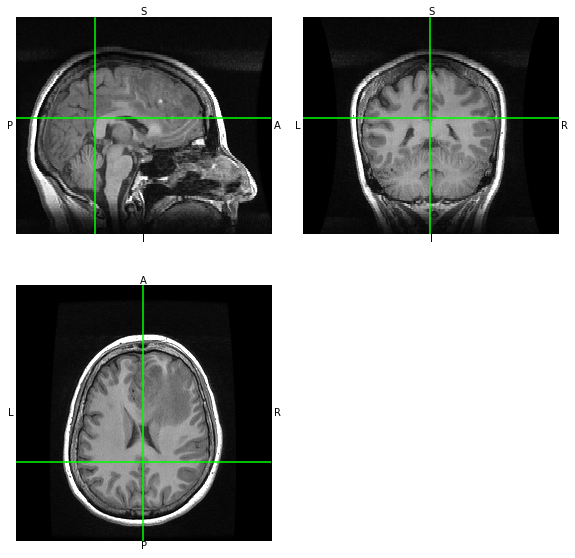

In [229]:
nib.load(t1_fpath).orthoview()

<OrthoSlicer3D: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/tmp_dcm_AX_T2_FRFSEXL_2MM_19961101102013_10a.nii.gz (256, 256, 85)>

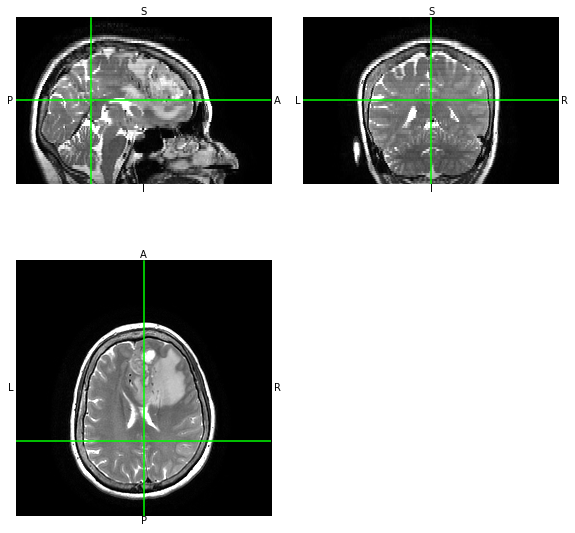

In [230]:
nib.load(t2_fpath).orthoview()

In [231]:
r = prep.run(t1_fpath=t1_fpath, t2_fpath=t2_fpath)[0]
r

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################



Traceback (most recent call last):
  File "/home/bruno-pacheco/anaconda3/envs/brats/bin/hd-bet", line 7, in <module>
    exec(compile(f.read(), __file__, 'exec'))
  File "/home/bruno-pacheco/HD-BET/HD_BET/hd-bet", line 119, in <module>
    run_hd_bet(input_files, output_files, mode, config_file, device, pp, tta, save_mask, overwrite_existing)
  File "/home/bruno-pacheco/HD-BET/HD_BET/run.py", line 63, in run_hd_bet
    net.cuda(device)
  File "/home/bruno-pacheco/anaconda3/envs/brats/lib/python3.8/site-packages/torch/nn/modules/module.py", line 463, in cuda
    return self._apply(lambda t: t.cuda(device))
  File "/home/bruno-pacheco/anaconda3/envs/brats/lib/python3.8/site-packages/torch/nn/modules/module.py", line 359, in _apply
    module._apply(fn)
  File "/home/bruno-pacheco/anaconda3/envs/brats/lib/python3.8/site-packages/torch/nn/modules/module.py", line 381, in _apply
    param_applied = fn(param)
  File "/home/bruno-pacheco/anaconda3/envs/brats/lib/python3.8/site-packages/torch/

CalledProcessError: Command 'hd-bet -i /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AX_T1_FSPGR_3D_PRE_19961101102013_9a.nii.gz -o .tmpdir/t1_template_tmp_dcm_AX_T1_FSPGR_3D_PRE_19961101102013_9a_mask -mode fast -device 0' returned non-zero exit status 1.

In [173]:
df_tcga_t1_fix = pd.read_csv('/home/felipe-sassi/Data/Selected_Series_TCGA_T1_WITH_BRATS_CORRECTED.csv')
df_tcga_t2_fix = pd.read_csv('/home/felipe-sassi/Data/Selected_Series_TCGA_T2_WITH_BRATS_CORRECTED.csv')

In [186]:
from subprocess import CalledProcessError

prep = PreprocessorHDBET(
    template_fpath='/home/bruno-pacheco/brats-generalization/data/external/SRI24_T1_brain.nii',
    tmpdir='.tmpdir',
    bet_modality='T1',
    mode='fast',
)

tmp_dcm_dir='.tmpdir/tmp_dcm'
Path(tmp_dcm_dir).mkdir(exist_ok=True)

target_dir = Path('/data/slow/PrepIMGs')
target_dir.mkdir(exist_ok=True)

sid_disaligned = list()
multiple_t1 = list()
multiple_t2 = list()

doesnt_exist_t1 = list()
doesnt_exist_t2 = list()

gen_error = list()
for t1_s, t2_s in tqdm(list(zip(df_tcga_t1_fix.sort_values(by='Subject ID').iloc, df_tcga_t2_fix.sort_values(by='Subject ID').iloc))):
    target_t1_fpath = target_dir/(t1_s['Subject ID'] + '_T1.nii')
    target_t2_fpath = target_dir/(t1_s['Subject ID'] + '_T2.nii')
    
    if target_t1_fpath.exists() and target_t2_fpath.exists():
        continue

    if t1_s['Subject ID'] != t2_s['Subject ID']:
        print(f"Problem at id {t1_s.name}")
        sid_disaligned.append(t1_s.name)
        continue
    
    if not Path(t1_s['File Location']).exists():
        doesnt_exist_t1.append(t1_s['File Location'])
        continue

    if not Path(t2_s['File Location']).exists():
        doesnt_exist_t2.append(t2_s['File Location'])
        continue

    t1_fpath = dcm_bad_dir_to_nifti(t1_s['File Location'])
    t2_fpath = dcm_bad_dir_to_nifti(t2_s['File Location'])

    if isinstance(t1_fpath, list):
        for i in range(len(t1_fpath)):
            t1_fpath_ = t1_fpath[i]
            
            try:
                r = prep.run(t1_fpath=t1_fpath_, t2_fpath=t2_fpath)[0]
            except CalledProcessError:
                gen_error.append(t1_s['Subject ID'])
                continue

            nib.save(r['t1'], str(target_t1_fpath).replace('T1', f'T1_{i}'))
            nib.save(r['t2'], target_t2_fpath)
        continue

    if isinstance(t2_fpath, list):
        for i in range(len(t2_fpath)):
            t2_fpath_ = t2_fpath[i]
            
            try:
                r = prep.run(t1_fpath=t1_fpath, t2_fpath=t2_fpath_)[0]
            except CalledProcessError:
                gen_error.append(t1_s['Subject ID'])
                continue

            nib.save(r['t1'], target_t1_fpath)
            nib.save(r['t2'], str(target_t2_fpath).replace('T2', f'T2_{i}'))
        continue

    try:
        r = prep.run(t1_fpath=t1_fpath, t2_fpath=t2_fpath)[0]
    except CalledProcessError:
        gen_error.append(t1_s['Subject ID'])
        continue

    nib.save(r['t1'], target_t1_fpath)
    nib.save(r['t2'], target_t2_fpath)

220518-14:39:04,660 nipype.interface INFO:
	 stdout 2022-05-18T14:39:04.660788:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220518-14:39:04,661 nipype.interface INFO:
	 stdout 2022-05-18T14:39:04.660788:Found 36 DICOM file(s)
220518-14:39:04,662 nipype.interface INFO:
	 stdout 2022-05-18T14:39:04.660788:Warning: Unable to determine manufacturer (0008,0070), so conversion is not tuned for vendor.
220518-14:39:04,662 nipype.interface INFO:
	 stdout 2022-05-18T14:39:04.660788:Convert 36 DICOM as .tmpdir/tmp_dcm_TVP_Surgical_6_20080111000000_7a (256x256x36x1)
220518-14:39:04,725 nipype.interface INFO:
	 stdout 2022-05-18T14:39:04.725322:Compress: "/usr/bin/pigz" -b 960 -n -f -6 ".tmpdir/tmp_dcm_TVP_Surgical_6_20080111000000_7a.nii"
220518-14:39:04,725 nipype.interface INFO:
	 stdout 2022-05-18T14:39:04.725322:Conversion required 0.382404 seconds (0.034097 for core code).
220518-14:39:05,263 nipype.interface INFO:
	 stdout 2022-05-18T14:39:05.263570:Chris Ro

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_TVP_Surgical_6_20080111000000_7a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_TVP_Surgical_6_20080111000000_7a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220518-14:39:46,582 nipype.interface INFO:
	 stdout 2022-05-18T14:39:46.582485:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220518-14:39:46,586 nipype.interface INFO:
	 stdout 2022-05-18T14:39:46.582485:Found 20 DICOM file(s)
220518-14:39:46,587 nipype.interface INFO:
	 stdout 2022-05-18T14:39:46.582485:Warning: Siemens 

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_BRAIN_STRYKER_T1_AXIAL_19970316215726_3a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_BRAIN_STRYKER_T1_AXIAL_19970316215726_3a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220518-14:40:20,218 nipype.interface INFO:
	 stdout 2022-05-18T14:40:20.217949:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220518-14:40:20,222 nipype.interface INFO:
	 stdout 2022-05-18T14:40:20.217949:Found 20 DICOM file(s)
220518-14:40:20,224 nipype.interface INFO:
	 stdout 2022-05-18T14:40:20.217949:Warning: 

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_BRAIN_STRYKER_T1_AXIAL_19980824120926_4a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_BRAIN_STRYKER_T1_AXIAL_19980824120926_4a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220518-14:40:54,406 nipype.interface INFO:
	 stdout 2022-05-18T14:40:54.406392:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220518-14:40:54,407 nipype.interface INFO:
	 stdout 2022-05-18T14:40:54.406392:Found 20 DICOM file(s)
220518-14:40:54,407 nipype.interface INFO:
	 stdout 2022-05-18T14:40:54.406392:Warning: 

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_BRAIN_STRYKER_T1_AXIAL_20010208144732_3a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_BRAIN_STRYKER_T1_AXIAL_20010208144732_3a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220518-14:41:28,281 nipype.interface INFO:
	 stdout 2022-05-18T14:41:28.281770:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220518-14:41:28,283 nipype.interface INFO:
	 stdout 2022-05-18T14:41:28.281770:Found 40 DICOM file(s)
220518-14:41:28,283 nipype.interface INFO:
	 stdout 2022-05-18T14:41:28.281770:Convert 4

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_19950428030111_6a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_19950428030111_6a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220518-14:42:12,190 nipype.interface INFO:
	 stdout 2022-05-18T14:42:12.190401:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220518-14:42:12,192 nipype.interface INFO:
	 stdout 2022-05-18T14:42:12.190401:Found 36 DICOM file(s)
220518-14:42:12,193 nipype.interface INFO:
	 stdout 2022-05-18T14:42:12.190401:Convert 36 DICOM as .tm

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_19951104235648_6a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_19951104235648_6a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220518-14:42:53,544 nipype.interface INFO:
	 stdout 2022-05-18T14:42:53.544687:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220518-14:42:53,545 nipype.interface INFO:
	 stdout 2022-05-18T14:42:53.544687:Found 71 DICOM file(s)
220518-14:42:53,546 nipype.interface INFO:
	 stdout 2022-05-18T14:42:53.544687:Convert 71 DICOM as .tm

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_19950223160415_11a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_19950223160415_11a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220518-14:43:42,774 nipype.interface INFO:
	 stdout 2022-05-18T14:43:42.774281:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220518-14:43:42,776 nipype.interface INFO:
	 stdout 2022-05-18T14:43:42.774281:Found 55 DICOM file(s)
220518-14:43:42,776 nipype.interface INFO:
	 stdout 2022-05-18T14:43:42.774281:Convert 55 DICOM as .t

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_PRE_GD_19850629020923_7a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_PRE_GD_19850629020923_7a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220518-14:44:27,409 nipype.interface INFO:
	 stdout 2022-05-18T14:44:27.409371:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220518-14:44:27,410 nipype.interface INFO:
	 stdout 2022-05-18T14:44:27.409371:Found 52 DICOM file(s)
220518-14:44:27,411 nipype.interface INFO:
	 stdout 2022-05-18T14:44:27.409371:Convert 52 DICOM

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_PRE_GD_19830723050848_7a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_PRE_GD_19830723050848_7a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220518-14:45:10,973 nipype.interface INFO:
	 stdout 2022-05-18T14:45:10.973228:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220518-14:45:10,974 nipype.interface INFO:
	 stdout 2022-05-18T14:45:10.973228:Found 58 DICOM file(s)
220518-14:45:10,975 nipype.interface INFO:
	 stdout 2022-05-18T14:45:10.973228:Convert 58 DICOM

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_PRE-GAD._19860307160147_6a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_PRE-GAD._19860307160147_6a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...
220518-14:46:09,323 nipype.interface INFO:
	 stdout 2022-05-18T14:46:09.323814:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220518-14:46:09,324 nipype.interface INFO:
	 stdout 2022-05-18T14:46:09.323814:Found 32 DICOM file(s)
220518-14:46:09,325 nipype.interface INFO:
	 stdout 2022-05-18T14:46:09.323814:Convert 32 DIC

Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_19910324101315_6a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...


Error: mkl-service + Intel(R) MKL: MKL_THREADING_LAYER=INTEL is incompatible with libgomp.so.1 library.
	Try to import numpy first or set the threading layer accordingly. Set MKL_SERVICE_FORCE_INTEL to force it.
/home/bruno-pacheco/HD-BET/HD_BET/utils.py:74: UserWarning: The argument 'neighbors' is deprecated and will be removed in scikit-image 0.18, use 'connectivity' instead. For neighbors=8, use connectivity=3
  lbls = label(mask, 8)



########################
If you are using hd-bet, please cite the following paper:
Isensee F, Schell M, Tursunova I, Brugnara G, Bonekamp D, Neuberger U, Wick A, Schlemmer HP, Heiland S, Wick W,Bendszus M, Maier-Hein KH, Kickingereder P. Automated brain extraction of multi-sequence MRI using artificialneural networks. arXiv preprint arXiv:1901.11341, 2019.
########################

File: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_AXIAL_T1_19910324101315_6a.nii.gz
preprocessing...
image shape after preprocessing:  (103, 160, 160)
prediction (CNN id)...
0
running postprocessing... 
exporting segmentation...



In [189]:
gen_error

[]

In [183]:
df_tcga_t2_fix.sort_values(by='Subject ID').iloc[multiple_t2]

,Unnamed: 0,Subject ID,Series Description,File Location,SET
3,3,TCGA-06-5408,AXIAL FSE,/data/slow/manifest-7AMtkRMr102480274090417257...,ONLY T2
63,63,TCGA-HT-7694,Prop T2 TRF,/data/slow/manifest-25ZdsnMy526409315046999320...,NOT ONLY T2
64,64,TCGA-HT-7879,Ax T2 Flair,/data/slow/manifest-25ZdsnMy526409315046999320...,NOT ONLY T2
66,66,TCGA-HT-8018,OPTIONAL AX FSE T2 inter,/data/slow/manifest-25ZdsnMy526409315046999320...,NOT ONLY T2
7,7,TCGA-76-6656,AXIAL T2,/data/slow/manifest-7AMtkRMr102480274090417257...,ONLY T2
44,44,TCGA-76-6657,T2 AX FLAIR,/data/slow/manifest-7AMtkRMr102480274090417257...,NOT ONLY T2
22,22,TCGA-DU-7301,AX T2 FR-FSE RF2 150,/data/slow/manifest-25ZdsnMy526409315046999320...,ONLY T2
46,46,TCGA-76-6662,T2 AX FLAIR,/data/slow/manifest-7AMtkRMr102480274090417257...,NOT ONLY T2
47,47,TCGA-76-6663,T2 AX FLAIR,/data/slow/manifest-7AMtkRMr102480274090417257...,NOT ONLY T2
48,48,TCGA-76-6664,T2-WHOLE BRAIN,/data/slow/manifest-7AMtkRMr102480274090417257...,NOT ONLY T2


In [184]:
df_tcga_t2_fix.sort_values(by='Subject ID').iloc[multiple_t2]['File Location'].values[0]

'/data/slow/manifest-7AMtkRMr1024802740904172577/TCGA-GBM/TCGA-06-5408/01-11-2008-NA-NA-34135/3.000000-AXIAL FSE-10343'

In [165]:
multiple_t1,multiple_t2

([151],
 [12,
  118,
  14,
  16,
  119,
  18,
  19,
  20,
  22,
  186,
  125,
  126,
  187,
  188,
  189,
  190,
  191,
  130,
  131,
  196,
  45,
  198,
  200,
  202,
  56,
  122,
  57,
  58,
  59,
  61,
  62,
  63,
  203,
  77,
  90])

In [172]:
df_tcga_t2.sort_values(by='Subject ID').iloc[multiple_t2]

,Unnamed: 0,Subject ID,Series Description,File Location,SET
115,115,TCGA-02-0069,FSE T2,/data/slow/BRATS_2021/train/00999/T2w,NOT ONLY T2
64,64,TCGA-DU-7008,AXIAL FSE,/data/slow/BRATS_2021/train/01494/T2w,ONLY T2
117,117,TCGA-02-0086,AX T2 FSE,/data/slow/BRATS_2021/train/00151/T2w,NOT ONLY T2
12,12,TCGA-06-0119,AXIAL FSE,/data/slow/BRATS_2021/train/00143/T2w,ONLY T2
65,65,TCGA-DU-7010,AXIAL FSE,/data/slow/BRATS_2021/train/01495/T2w,ONLY T2
118,118,TCGA-06-0128,AXIAL FSE,/data/slow/manifest-7AMtkRMr102480274090417257...,NOT ONLY T2
14,14,TCGA-06-0129,AXIAL FSE,/data/slow/manifest-7AMtkRMr102480274090417257...,ONLY T2
15,15,TCGA-06-0133,AX T2 FR-FSE RF2 150,/data/slow/manifest-7AMtkRMr102480274090417257...,ONLY T2
119,119,TCGA-06-0142,AXIAL FSE,/data/slow/BRATS_2021/train/00132/T2w,NOT ONLY T2
157,157,TCGA-HT-7690,Prop T2 TRF,/data/slow/BRATS_2021/train/01532/T2w,NOT ONLY T2


In [166]:
doesnt_exist_t1, doesnt_exist_t2

(['/data/slow/BRATS_2021/train/01281/T1w',
  '/data/slow/BRATS_2021/train/01282/T1w',
  '/data/slow/BRATS_2021/train/01283/T1w',
  '/data/slow/BRATS_2021/train/01455/T1w',
  '/data/slow/BRATS_2021/train/01470/T1w',
  '/data/slow/BRATS_2021/train/01471/T1w',
  '/data/slow/BRATS_2021/train/01474/T1w',
  '/data/slow/BRATS_2021/train/01139/T1w',
  '/data/slow/BRATS_2021/train/01140/T1w',
  '/data/slow/BRATS_2021/train/01475/T1w',
  '/data/slow/BRATS_2021/train/01141/T1w',
  '/data/slow/BRATS_2021/train/01142/T1w',
  '/data/slow/BRATS_2021/train/01143/T1w',
  '/data/slow/BRATS_2021/train/01144/T1w',
  '/data/slow/BRATS_2021/train/01145/T1w',
  '/data/slow/BRATS_2021/train/01146/T1w',
  '/data/slow/BRATS_2021/train/01476/T1w',
  '/data/slow/BRATS_2021/train/01477/T1w',
  '/data/slow/BRATS_2021/train/01478/T1w',
  '/data/slow/BRATS_2021/train/01479/T1w',
  '/data/slow/BRATS_2021/train/01480/T1w',
  '/data/slow/BRATS_2021/train/01481/T1w',
  '/data/slow/BRATS_2021/train/01482/T1w',
  '/data/sl

In [161]:
df_tcga_t1.sort_values(by='Subject ID').head()

,Unnamed: 0,Subject ID,Series Description,File Location,SET
0,0,TCGA-02-0003,AX T1,/data/slow/manifest-7AMtkRMr102480274090417257...,ONLY T1
1,1,TCGA-02-0006,AX T1,/data/slow/BRATS_2021/train/00113/T1w,ONLY T1
2,2,TCGA-02-0009,AX T1,/data/slow/BRATS_2021/train/00149/T1w,ONLY T1
3,3,TCGA-02-0011,AX T1,/data/slow/BRATS_2021/train/01003/T1w,ONLY T1
4,4,TCGA-02-0027,Ax SE T1 Post,/data/slow/BRATS_2021/train/01009/T1w,ONLY T1


In [162]:
df_tcga_t2.sort_values(by='Subject ID').head()

,Unnamed: 0,Subject ID,Series Description,File Location,SET
0,0,TCGA-02-0003,AX T2 FSE,/data/slow/manifest-7AMtkRMr102480274090417257...,ONLY T2
1,1,TCGA-02-0006,AX T2 FSE,/data/slow/BRATS_2021/train/00113/T2w,ONLY T2
2,2,TCGA-02-0009,AX T2 FSE,/data/slow/BRATS_2021/train/00149/T2w,ONLY T2
3,3,TCGA-02-0011,AX T2 FSE,/data/slow/BRATS_2021/train/01003/T2w,ONLY T2
4,4,TCGA-02-0027,FSE T2,/data/slow/BRATS_2021/train/01009/T2w,ONLY T2


<OrthoSlicer3D: /data/slow/PrepIMGs/TCGA-02-0011_T1.nii (240, 240, 155)>

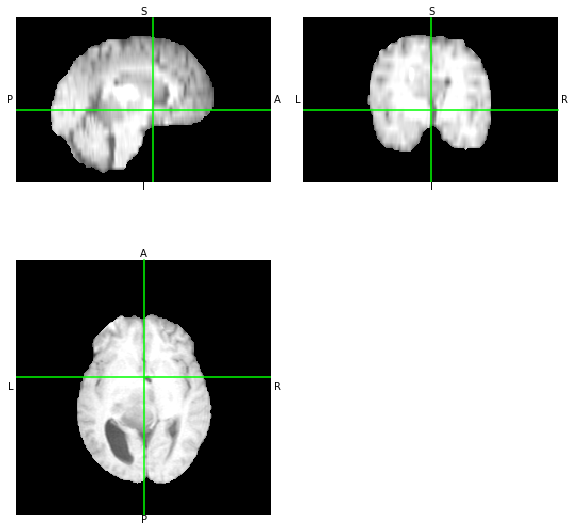

In [150]:
nib.load('/data/slow/PrepIMGs/TCGA-02-0011_T1.nii').orthoview()

In [142]:
t1_s

Unnamed: 0                                                9
Subject ID                                     TCGA-02-0047
Series Description                                    AX T1
File Location         /data/slow/BRATS_2021/train/00123/T1w
SET                                                 ONLY T1
Name: 9, dtype: object

In [137]:
f = dcm2nifti('/data/slow/BRATS_2021/train/00123/T1w', '.tmpdir')
f

220516-16:38:31,951 nipype.interface INFO:
	 stdout 2022-05-16T16:38:31.951238:Chris Rorden's dcm2niiX version v1.0.20201102  GCC7.5.0 x86-64 (64-bit Linux)
220516-16:38:31,952 nipype.interface INFO:
	 stdout 2022-05-16T16:38:31.951238:Found 23 DICOM file(s)
220516-16:38:31,952 nipype.interface INFO:
	 stdout 2022-05-16T16:38:31.951238:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '/data/slow/BRATS_2021/train/00123/T1w/Image-19.dcm'
220516-16:38:31,952 nipype.interface INFO:
	 stdout 2022-05-16T16:38:31.951238:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '/data/slow/BRATS_2021/train/00123/T1w/Image-8.dcm'
220516-16:38:31,953 nipype.interface INFO:
	 stdout 2022-05-16T16:38:31.951238:DICOM appears corrupt: first group:element should be 0x0002:0x0000 '/data/slow/BRATS_2021/train/00123/T1w/Image-9.dcm'
220516-16:38:31,953 nipype.interface INFO:
	 stdout 2022-05-16T16:38:31.951238:DICOM appears corrupt: first group:element should be 0x0002:0x0000 

PosixPath('/home/bruno-pacheco/brain-age/notebooks/.tmpdir/T1w_T1w_0_5.nii.gz')

In [141]:
nib.load(f).get_fdata().min()

0.0

In [134]:
!ls {t1_s['File Location']}

Image-1.dcm   Image-14.dcm  Image-19.dcm  Image-23.dcm	Image-7.dcm
Image-10.dcm  Image-15.dcm  Image-2.dcm   Image-3.dcm	Image-8.dcm
Image-11.dcm  Image-16.dcm  Image-20.dcm  Image-4.dcm	Image-9.dcm
Image-12.dcm  Image-17.dcm  Image-21.dcm  Image-5.dcm
Image-13.dcm  Image-18.dcm  Image-22.dcm  Image-6.dcm


<OrthoSlicer3D: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/tmp_dcm_T1w_0_5.nii.gz (256, 256, 23)>

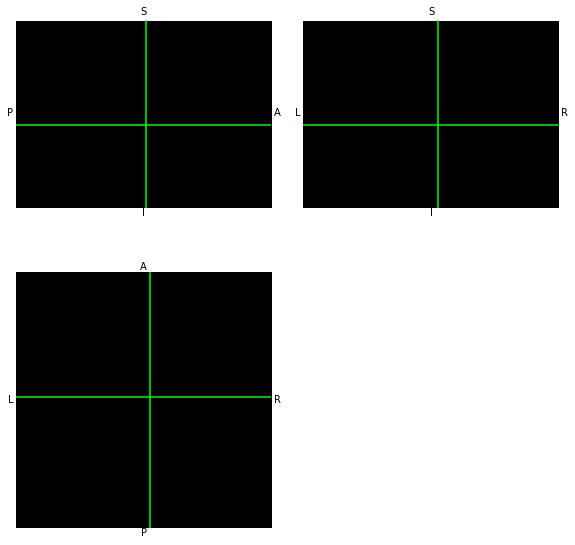

In [131]:
nib.load(t1_fpath).orthoview()

<OrthoSlicer3D: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_5.nii.gz (240, 240, 155)>

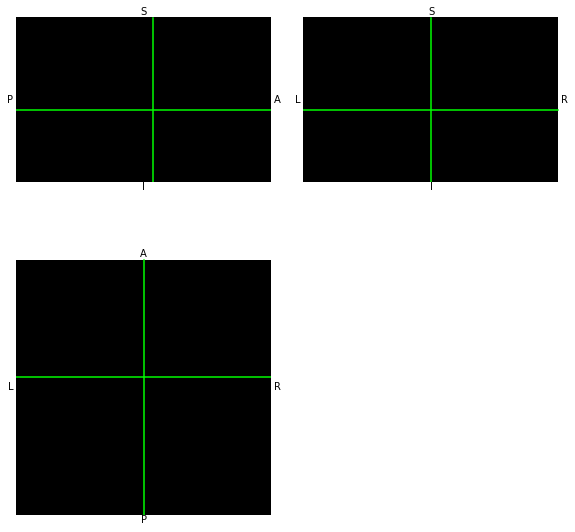

In [127]:
nib.load('/home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_5.nii.gz').orthoview()

In [124]:
!ls {t1_s['File Location']}

Image-1.dcm   Image-14.dcm  Image-19.dcm  Image-23.dcm	Image-7.dcm
Image-10.dcm  Image-15.dcm  Image-2.dcm   Image-3.dcm	Image-8.dcm
Image-11.dcm  Image-16.dcm  Image-20.dcm  Image-4.dcm	Image-9.dcm
Image-12.dcm  Image-17.dcm  Image-21.dcm  Image-5.dcm
Image-13.dcm  Image-18.dcm  Image-22.dcm  Image-6.dcm


In [119]:
t1_s

Unnamed: 0                                                9
Subject ID                                     TCGA-02-0047
Series Description                                    AX T1
File Location         /data/slow/BRATS_2021/train/00123/T1w
SET                                                 ONLY T1
Name: 9, dtype: object

In [120]:
!ls /data/slow/BRATS_2021/train/00123/T1w

Image-1.dcm   Image-14.dcm  Image-19.dcm  Image-23.dcm	Image-7.dcm
Image-10.dcm  Image-15.dcm  Image-2.dcm   Image-3.dcm	Image-8.dcm
Image-11.dcm  Image-16.dcm  Image-20.dcm  Image-4.dcm	Image-9.dcm
Image-12.dcm  Image-17.dcm  Image-21.dcm  Image-5.dcm
Image-13.dcm  Image-18.dcm  Image-22.dcm  Image-6.dcm


In [121]:
!rm -rf .tmpdir/*

<OrthoSlicer3D: /home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_5e.nii.gz (240, 240, 155)>

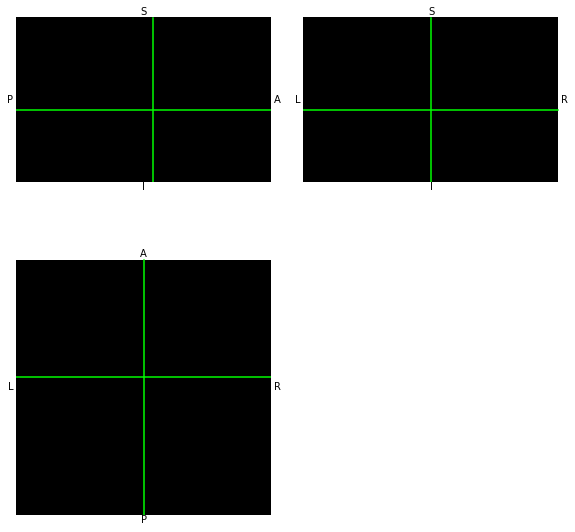

In [118]:
nib.load('/home/bruno-pacheco/brain-age/notebooks/.tmpdir/t1_template_tmp_dcm_T1w_0_5e.nii.gz').orthoview()

In [113]:
Path(df_tcga_t1.iloc[8]['File Location']).exists()

False

In [108]:
!ls /data/slow/BRATS_2021/train/00123

FLAIR  T1w  T1wCE  T2w


# Make pred dir

In [42]:
df_t1 = pd.read_csv('/home/felipe-sassi/Data/TCIA_T1_MASTER_DATASET.csv').set_index('Subject ID')
df_t1.head()

,Path,Filename
Subject ID,,
W9,/data/slow/PrepIMGs/W9_T1.nii,W9_T1.nii
W7,/data/slow/PrepIMGs/W7_T1.nii,W7_T1.nii
W5,/data/slow/PrepIMGs/W5_T1.nii,W5_T1.nii
W54,/data/slow/PrepIMGs/W54_T1.nii,W54_T1.nii
W39,/data/slow/PrepIMGs/W39_T1.nii,W39_T1.nii


In [41]:
df_t2 = pd.read_csv('/home/felipe-sassi/Data/TCIA_T2_MASTER_DATASET.csv').set_index('Subject ID')
df_t2.head()

,Path,Filename
Subject ID,,
TCGA-02-0003,/data/slow/PrepIMGs/TCGA-02-0003_T2.nii,TCGA-02-0003_T2.nii
TCGA-02-0006,/data/slow/PrepIMGs/TCGA-02-0006_T2.nii,TCGA-02-0006_T2.nii
TCGA-02-0009,/data/slow/PrepIMGs/TCGA-02-0009_T2.nii,TCGA-02-0009_T2.nii
TCGA-02-0011,/data/slow/PrepIMGs/TCGA-02-0011_T2.nii,TCGA-02-0011_T2.nii
TCGA-02-0027,/data/slow/PrepIMGs/TCGA-02-0027_T2.nii,TCGA-02-0027_T2.nii


In [47]:
df = pd.DataFrame([df_t1['Path'], df_t2['Path']]).T
df.columns = ['T1', 'T2']
df

,T1,T2
W9,/data/slow/PrepIMGs/W9_T1.nii,/data/slow/PrepIMGs/W9_T2.nii
W7,/data/slow/PrepIMGs/W7_T1.nii,/data/slow/PrepIMGs/W7_T2.nii
W5,/data/slow/PrepIMGs/W5_T1.nii,/data/slow/PrepIMGs/W5_T2.nii
W54,/data/slow/PrepIMGs/W54_T1.nii,/data/slow/PrepIMGs/W54_T2.nii
W39,/data/slow/PrepIMGs/W39_T1.nii,/data/slow/PrepIMGs/W39_T2.nii
...,...,...
TCGA-02-0027,/data/slow/PrepIMGs/TCGA-02-0027_T1.nii,/data/slow/PrepIMGs/TCGA-02-0027_T2.nii
TCGA-02-0011,/data/slow/PrepIMGs/TCGA-02-0011_T1.nii,/data/slow/PrepIMGs/TCGA-02-0011_T2.nii
TCGA-02-0009,/data/slow/PrepIMGs/TCGA-02-0009_T1.nii,/data/slow/PrepIMGs/TCGA-02-0009_T2.nii
TCGA-02-0006,/data/slow/PrepIMGs/TCGA-02-0006_T1.nii,/data/slow/PrepIMGs/TCGA-02-0006_T2.nii


In [51]:
s = df.iloc[0]
s

T1    /data/slow/PrepIMGs/W9_T1.nii
T2    /data/slow/PrepIMGs/W9_T2.nii
Name: W9, dtype: object

In [52]:
inference_dir = Path('/home/bruno-pacheco/brats-generalization/data/processed/IMGs')
inference_dir.exists()

True

In [59]:
for s in tqdm(df.iloc):
    t2_fpath = Path(s['T2'])
    t1_fpath = Path(s['T1'])

    assert t2_fpath.exists()
    assert t1_fpath.exists()

    t2_fpath_inference = inference_dir/(s.name + '_0001.nii.gz')
    t1_fpath_inference = inference_dir/(s.name + '_0000.nii.gz')

    if t1_fpath_inference.exists():
        t1_fpath_inference.unlink()

    if t2_fpath_inference.exists():
        t2_fpath_inference.unlink()

    nib.save(nib.load(t1_fpath), t1_fpath_inference)
    nib.save(nib.load(t2_fpath), t2_fpath_inference)

In [54]:
copy

<function shutil.copy(src, dst, *, follow_symlinks=True)>

In [55]:
fpath.name

'TCGA-HT-7481.nii.gz'

In [61]:
for fpath in Path('/home/bruno-pacheco/brats-generalization/data/processed/IMGs').glob('*.nii.gz'):
    dst_fpath = '/data/slow/PrepIMGs/'+fpath.name.replace('0000', 'T1').replace('0001', 'T2')
    nib.save(nib.load(fpath), dst_fpath)

In [60]:
fpath

PosixPath('/home/bruno-pacheco/brats-generalization/data/processed/IMGs/TCGA-DU-A5TU_0001.nii.gz')

In [52]:
!ls ~/brats-generalization/data/predictions/IMGs

plans.pkl	     TCGA-CS-5394.nii.gz  TCGA-FG-A6J1.nii.gz
TCGA-02-0003.nii.gz  TCGA-CS-5395.nii.gz  TCGA-FG-A713.nii.gz
TCGA-02-0006.nii.gz  TCGA-CS-5396.nii.gz  TCGA-FG-A87N.nii.gz
TCGA-02-0009.nii.gz  TCGA-CS-5397.nii.gz  TCGA-HT-7468.nii.gz
TCGA-02-0011.nii.gz  TCGA-CS-6186.nii.gz  TCGA-HT-7469.nii.gz
TCGA-02-0027.nii.gz  TCGA-CS-6188.nii.gz  TCGA-HT-7471.nii.gz
TCGA-02-0033.nii.gz  TCGA-CS-6290.nii.gz  TCGA-HT-7472.nii.gz
TCGA-02-0034.nii.gz  TCGA-CS-6665.nii.gz  TCGA-HT-7473.nii.gz
TCGA-02-0037.nii.gz  TCGA-CS-6666.nii.gz  TCGA-HT-7475.nii.gz
TCGA-02-0046.nii.gz  TCGA-CS-6667.nii.gz  TCGA-HT-7476.nii.gz
TCGA-02-0060.nii.gz  TCGA-CS-6668.nii.gz  TCGA-HT-7478.nii.gz
TCGA-02-0064.nii.gz  TCGA-CS-6669.nii.gz  TCGA-HT-7481.nii.gz
TCGA-02-0069.nii.gz  TCGA-DU-5849.nii.gz  TCGA-HT-7602.nii.gz
TCGA-06-0128.nii.gz  TCGA-DU-5851.nii.gz  TCGA-HT-7603.nii.gz
TCGA-06-0129.nii.gz  TCGA-DU-5852.nii.gz  TCGA-HT-7605.nii.gz
TCGA-06-0133.nii.gz  TCGA-DU-5853.nii.gz  TCGA-HT-7606.nii.gz
TCGA-06-0142.n

<OrthoSlicer3D: /data/slow/PrepIMGs/TCGA-02-0003_T1.nii (240, 240, 155)>

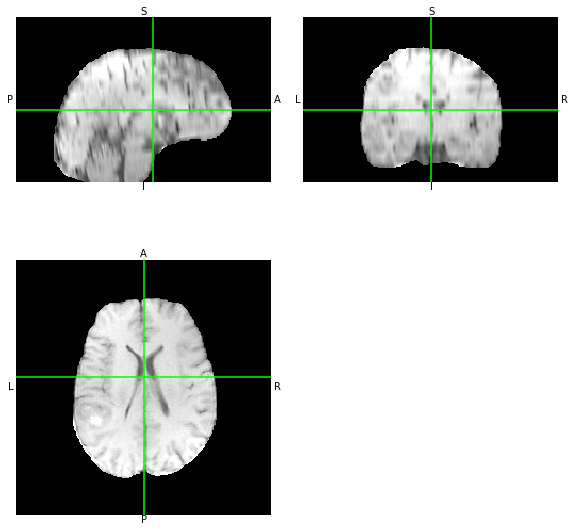

In [258]:
nib.load(t1_fpath).orthoview()

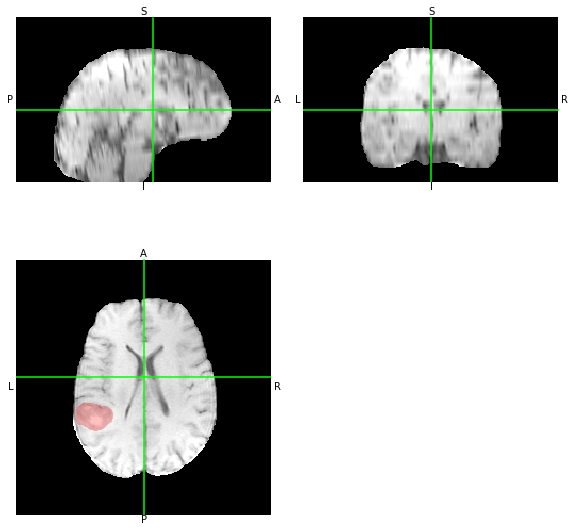

In [18]:
show_mri(t1_fpath, overlay='/home/bruno-pacheco/brats-generalization/data/predictions/IMGs/TCGA-02-0003.nii.gz', overlay_label=2, pos=(0,0,0))

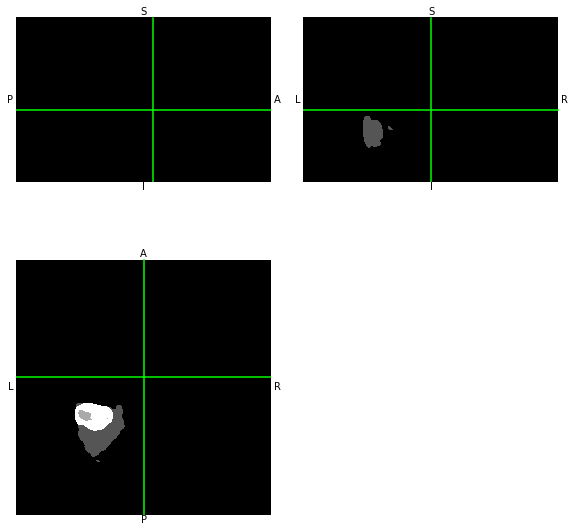

In [14]:
show_mri(, pos=(0,0,0))

In [274]:
show_mri(nib.load(t1_fpath),crop=(1.1,1.1,1.1))

TypeError: show_mri() got an unexpected keyword argument 'crop'

In [262]:
show_mri('/home/bruno-pacheco/brats-generalization/data/predictions/IMGs/TCGA-02-0003.nii.gz', pos=(0,0,0))

IndexError: cannot do a non-empty take from an empty axes.

# Data check

In [111]:
yog = pd.read_csv('/home/bruno-pacheco/brats-generalization/yogananda.csv')
yog['ID'] = yog['Subject ID'].apply(lambda s: s.split('_')[0])
yog

,Subject ID,Age,Gender,Unnamed: 3,Histology,Grade,TCGA Data Collection,IDH\nmutation Status,1p/19q co- deletion\nstatus,MGMT\npromoter status,Survival (months),Karnofsky performance scores,Cross- validation group,ID
0,TCGA-02-0003,50.0,male,NaN,glioblastoma,G4,TCGA-GBM,WT,non-codel,Unmethylated,4.731106,100.0,2,TCGA-02-0003
1,TCGA-02-0006,56.0,female,NaN,glioblastoma,G4,TCGA-GBM,WT,non-codel,Unmethylated,18.333034,80.0,2,TCGA-02-0006
2,TCGA-02-0009,61.0,female,NaN,glioblastoma,G4,TCGA-GBM,WT,non-codel,Unmethylated,10.579278,80.0,2,TCGA-02-0009
3,TCGA-02-0011,18.0,female,NaN,glioblastoma,G4,TCGA-GBM,WT,non-codel,Methylated,20.698587,80.0,2,TCGA-02-0011
4,TCGA-02-0027,33.0,female,NaN,glioblastoma,G4,TCGA-GBM,WT,non-codel,Unmethylated,12.156313,100.0,2,TCGA-02-0027
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
242,W39_19980919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Methylated,NaN,NaN,1,W39
243,W5_19961211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unmethylated,NaN,NaN,3,W5
244,W54_20000902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unmethylated,NaN,NaN,3,W54
245,W7_19961218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Methylated,NaN,NaN,1,W7


In [26]:
(yog['Subject ID'].iloc[:224] == yog['ID'].iloc[:224]).all()

True

In [32]:
yog_tcga_ids = yog[yog['Subject ID'].str.startswith('TCGA')]['Subject ID']
yog_tcga_ids

0      TCGA-02-0003
1      TCGA-02-0006
2      TCGA-02-0009
3      TCGA-02-0011
4      TCGA-02-0027
           ...     
219    TCGA-HT-A5RB
220    TCGA-HT-A5RC
221    TCGA-HT-A616
222    TCGA-HT-A61A
223    TCGA-HT-A61B
Name: Subject ID, Length: 224, dtype: object

In [30]:
brats_tcga = pd.read_csv('/home/bruno-pacheco/brats-generalization/data/raw/MICCAI_BraTS2020_TrainingData/name_mapping.csv')['TCGA_TCIA_subject_ID']
brats_tcga.dropna()

157    TCGA-02-0006
158    TCGA-02-0009
159    TCGA-02-0011
160    TCGA-02-0027
161    TCGA-02-0033
           ...     
330    TCGA-HT-8018
331    TCGA-HT-8111
332    TCGA-HT-8114
333    TCGA-HT-8563
334    TCGA-HT-A61A
Name: TCGA_TCIA_subject_ID, Length: 167, dtype: object

In [37]:
len(set(yog_tcga_ids.values).intersection(set(brats_tcga.values)))

113

In [39]:
set(brats_tcga.values).difference(set(yog_tcga_ids.values))

{'TCGA-02-0054',
 'TCGA-02-0059',
 'TCGA-02-0068',
 'TCGA-02-0070',
 'TCGA-02-0085',
 'TCGA-02-0087',
 'TCGA-02-0106',
 'TCGA-02-0116',
 'TCGA-06-0130',
 'TCGA-06-0138',
 'TCGA-06-0139',
 'TCGA-06-0149',
 'TCGA-06-0154',
 'TCGA-06-0158',
 'TCGA-06-0162',
 'TCGA-06-0164',
 'TCGA-06-0176',
 'TCGA-06-0177',
 'TCGA-06-0179',
 'TCGA-06-0182',
 'TCGA-06-0184',
 'TCGA-06-0185',
 'TCGA-06-0187',
 'TCGA-06-0188',
 'TCGA-06-0190',
 'TCGA-06-0192',
 'TCGA-06-0238',
 'TCGA-06-0240',
 'TCGA-06-0644',
 'TCGA-06-0646',
 'TCGA-06-1084',
 'TCGA-06-1802',
 'TCGA-08-0355',
 'TCGA-08-0356',
 'TCGA-08-0359',
 'TCGA-08-0360',
 'TCGA-08-0385',
 'TCGA-08-0389',
 'TCGA-08-0390',
 'TCGA-08-0392',
 'TCGA-08-0509',
 'TCGA-08-0512',
 'TCGA-08-0520',
 'TCGA-08-0522',
 'TCGA-12-0616',
 'TCGA-12-0776',
 'TCGA-12-1094',
 'TCGA-12-1098',
 'TCGA-14-1825',
 'TCGA-19-0963',
 'TCGA-19-5951',
 'TCGA-19-5960',
 'TCGA-DU-6542',
 'TCGA-DU-7014',
 nan}

In [53]:
','.join(set(yog_tcga_ids.values).difference(set(brats_tcga.values)))

'TCGA-FG-A4MU,TCGA-76-4926,TCGA-CS-5390,TCGA-DU-6400,TCGA-HT-7860,TCGA-DU-A6S6,TCGA-FG-6688,TCGA-CS-6667,TCGA-FG-5963,TCGA-FG-A6J1,TCGA-HT-7468,TCGA-HT-A616,TCGA-HT-7469,TCGA-FG-7637,TCGA-HT-7478,TCGA-DU-6395,TCGA-06-0147,TCGA-HT-7855,TCGA-DU-6401,TCGA-DU-6407,TCGA-02-0060,TCGA-HT-7471,TCGA-06-1806,TCGA-76-4925,TCGA-HT-A5R5,TCGA-HT-7606,TCGA-14-0789,TCGA-HT-8105,TCGA-FG-A713,TCGA-27-1836,TCGA-DU-5871,TCGA-HT-7693,TCGA-CS-5395,TCGA-06-5412,TCGA-06-0129,TCGA-HT-7608,TCGA-HT-7902,TCGA-HT-8013,TCGA-DU-6408,TCGA-76-6286,TCGA-DU-A6S2,TCGA-HT-A5RB,TCGA-HT-8107,TCGA-12-1093,TCGA-76-6192,TCGA-HT-7692,TCGA-76-4928,TCGA-06-0133,TCGA-DU-5853,TCGA-HT-7874,TCGA-HT-7472,TCGA-HT-7616,TCGA-HT-7475,TCGA-HT-7856,TCGA-DU-A5TP,TCGA-FG-A87N,TCGA-HT-8564,TCGA-HT-7684,TCGA-CS-5394,TCGA-06-0143,TCGA-HT-8019,TCGA-76-4927,TCGA-27-1838,TCGA-HT-7481,TCGA-19-1791,TCGA-06-0148,TCGA-HT-8113,TCGA-76-4929,TCGA-HT-7476,TCGA-CS-6290,TCGA-HT-7695,TCGA-CS-4941,TCGA-FG-6690,TCGA-19-1390,TCGA-HT-8106,TCGA-CS-4943,TCGA-06-012

In [63]:
set(yog_tcga_ids.values).difference(set(brats_tcga.values))

{'TCGA-02-0003',
 'TCGA-02-0060',
 'TCGA-06-0128',
 'TCGA-06-0129',
 'TCGA-06-0133',
 'TCGA-06-0143',
 'TCGA-06-0147',
 'TCGA-06-0148',
 'TCGA-06-0881',
 'TCGA-06-1806',
 'TCGA-06-5412',
 'TCGA-12-1093',
 'TCGA-12-1602',
 'TCGA-14-0789',
 'TCGA-14-1829',
 'TCGA-19-1390',
 'TCGA-19-1791',
 'TCGA-19-2620',
 'TCGA-19-5953',
 'TCGA-27-1830',
 'TCGA-27-1835',
 'TCGA-27-1836',
 'TCGA-27-1838',
 'TCGA-76-4925',
 'TCGA-76-4926',
 'TCGA-76-4927',
 'TCGA-76-4928',
 'TCGA-76-4929',
 'TCGA-76-4931',
 'TCGA-76-6192',
 'TCGA-76-6286',
 'TCGA-CS-4938',
 'TCGA-CS-4941',
 'TCGA-CS-4943',
 'TCGA-CS-5390',
 'TCGA-CS-5394',
 'TCGA-CS-5395',
 'TCGA-CS-6290',
 'TCGA-CS-6667',
 'TCGA-DU-5849',
 'TCGA-DU-5852',
 'TCGA-DU-5853',
 'TCGA-DU-5871',
 'TCGA-DU-6395',
 'TCGA-DU-6397',
 'TCGA-DU-6399',
 'TCGA-DU-6400',
 'TCGA-DU-6401',
 'TCGA-DU-6405',
 'TCGA-DU-6407',
 'TCGA-DU-6408',
 'TCGA-DU-7013',
 'TCGA-DU-8158',
 'TCGA-DU-8165',
 'TCGA-DU-A5TP',
 'TCGA-DU-A6S2',
 'TCGA-DU-A6S3',
 'TCGA-DU-A6S6',
 'TCGA-FG-5963

In [37]:
len(set(yog_tcga_ids.values).intersection(set(brats_tcga.values)))

113

In [112]:
yog['is_prep'] = yog['ID'].apply(lambda s: len(list(Path("/data/slow/PrepIMGs").glob(f"{s}_*"))) > 0)
yog['is_prep'].value_counts()

True    247
Name: is_prep, dtype: int64

In [67]:
','.join(yog[~yog['is_prep']]['ID'].values)

'TCGA-02-0047,TCGA-76-4925,W34,W36,W38,W39,W5,W54,W7,W9'

In [68]:
yog[~yog['is_prep']]

,Subject ID,Age,Gender,Unnamed: 3,Histology,Grade,TCGA Data Collection,IDH\nmutation Status,1p/19q co- deletion\nstatus,MGMT\npromoter status,Survival (months),Karnofsky performance scores,Cross- validation group,ID,is_prep
9,TCGA-02-0047,78.0,male,NaN,glioblastoma,G4,TCGA-GBM,WT,non-codel,Unmethylated,14.718995,80.0,1,TCGA-02-0047,False
59,TCGA-76-4925,76.0,male,NaN,glioblastoma,G4,TCGA-GBM,WT,non-codel,Methylated,4.796815,100.0,2,TCGA-76-4925,False
239,W34_19980713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unmethylated,NaN,NaN,2,W34,False
240,W36_19980714,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unmethylated,NaN,NaN,1,W36,False
241,W38_19980910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Methylated,NaN,NaN,2,W38,False
242,W39_19980919,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Methylated,NaN,NaN,1,W39,False
243,W5_19961211,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unmethylated,NaN,NaN,3,W5,False
244,W54_20000902,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unmethylated,NaN,NaN,3,W54,False
245,W7_19961218,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Methylated,NaN,NaN,1,W7,False
246,W9_19970410,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Unmethylated,NaN,NaN,3,W9,False


# HDF5

In [42]:
df_t1 = pd.read_csv('/home/felipe-sassi/Data/TCIA_T1_MASTER_DATASET.csv').set_index('Subject ID')
df_t1.head()

,Path,Filename
Subject ID,,
W9,/data/slow/PrepIMGs/W9_T1.nii,W9_T1.nii
W7,/data/slow/PrepIMGs/W7_T1.nii,W7_T1.nii
W5,/data/slow/PrepIMGs/W5_T1.nii,W5_T1.nii
W54,/data/slow/PrepIMGs/W54_T1.nii,W54_T1.nii
W39,/data/slow/PrepIMGs/W39_T1.nii,W39_T1.nii


In [41]:
df_t2 = pd.read_csv('/home/felipe-sassi/Data/TCIA_T2_MASTER_DATASET.csv').set_index('Subject ID')
df_t2.head()

,Path,Filename
Subject ID,,
TCGA-02-0003,/data/slow/PrepIMGs/TCGA-02-0003_T2.nii,TCGA-02-0003_T2.nii
TCGA-02-0006,/data/slow/PrepIMGs/TCGA-02-0006_T2.nii,TCGA-02-0006_T2.nii
TCGA-02-0009,/data/slow/PrepIMGs/TCGA-02-0009_T2.nii,TCGA-02-0009_T2.nii
TCGA-02-0011,/data/slow/PrepIMGs/TCGA-02-0011_T2.nii,TCGA-02-0011_T2.nii
TCGA-02-0027,/data/slow/PrepIMGs/TCGA-02-0027_T2.nii,TCGA-02-0027_T2.nii


In [47]:
df = pd.DataFrame([df_t1['Path'], df_t2['Path']]).T
df.columns = ['T1', 'T2']
df

,T1,T2
W9,/data/slow/PrepIMGs/W9_T1.nii,/data/slow/PrepIMGs/W9_T2.nii
W7,/data/slow/PrepIMGs/W7_T1.nii,/data/slow/PrepIMGs/W7_T2.nii
W5,/data/slow/PrepIMGs/W5_T1.nii,/data/slow/PrepIMGs/W5_T2.nii
W54,/data/slow/PrepIMGs/W54_T1.nii,/data/slow/PrepIMGs/W54_T2.nii
W39,/data/slow/PrepIMGs/W39_T1.nii,/data/slow/PrepIMGs/W39_T2.nii
...,...,...
TCGA-02-0027,/data/slow/PrepIMGs/TCGA-02-0027_T1.nii,/data/slow/PrepIMGs/TCGA-02-0027_T2.nii
TCGA-02-0011,/data/slow/PrepIMGs/TCGA-02-0011_T1.nii,/data/slow/PrepIMGs/TCGA-02-0011_T2.nii
TCGA-02-0009,/data/slow/PrepIMGs/TCGA-02-0009_T1.nii,/data/slow/PrepIMGs/TCGA-02-0009_T2.nii
TCGA-02-0006,/data/slow/PrepIMGs/TCGA-02-0006_T1.nii,/data/slow/PrepIMGs/TCGA-02-0006_T2.nii


In [64]:
s = df.iloc[-1]
s

T1    /data/slow/PrepIMGs/TCGA-02-0003_T1.nii
T2    /data/slow/PrepIMGs/TCGA-02-0003_T2.nii
Name: TCGA-02-0003, dtype: object

In [104]:
nib.load(Path('/home/bruno-pacheco/brats-generalization/data/predictions/IMGs/')/f"{s.name}.nii.gz").get_fdata().min()

0.0

In [65]:
nib.load(s['T1']).affine

array([[   1.,    0.,   -0., -120.],
       [   0.,    1.,   -0., -129.],
       [   0.,    0.,    1.,  -68.],
       [   0.,    0.,    0.,    1.]])

In [70]:
nib.load(s['T2']).affine

array([[   1.,    0.,   -0., -120.],
       [   0.,    1.,   -0., -129.],
       [   0.,    0.,    1.,  -68.],
       [   0.,    0.,    0.,    1.]])

In [85]:
import matplotlib.pyplot as plt
import numpy as np

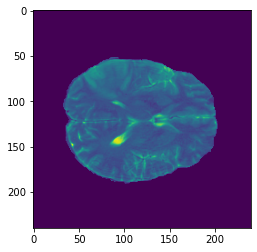

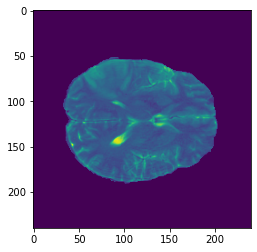

In [87]:
img = nib.load(s['T2'])
data = img.get_fdata()
plt.imshow(data[:,:,60])
plt.show()
for i, aff in enumerate(np.diag(img.affine)[:-1]):
    if aff < 0:
        data = np.flip(data, axis=i)
plt.imshow(data[:,:,60])
plt.show()

## Create HDF

In [131]:
import h5py

with h5py.File('/data/slow/yogananda.hdf5', 'w') as h:
    X = h.create_dataset(
        'X',
        (244,2,240,240,155),
        dtype='float64',
        chunks=(1,2,240,240,155),
        compression='gzip',
    )

    y = h.create_dataset(
        'y',
        (244,),
        dtype='uint8',
    )

    seg = h.create_dataset(
        'seg',
        (244,240,240,155),
        dtype='uint8',
        chunks=(1,240,240,155),
        compression='gzip',
    )

    seg.attrs['ids'] = y.attrs['ids'] = X.attrs['ids'] = list(df.index.values)

In [118]:
mgmt_data = yog.set_index('ID')['MGMT\npromoter status'] == 'Methylated'
mgmt_data = mgmt_data.astype('uint8')
mgmt_data

ID
TCGA-02-0003    0
TCGA-02-0006    0
TCGA-02-0009    0
TCGA-02-0011    1
TCGA-02-0027    0
               ..
W39             1
W5              0
W54             0
W7              1
W9              0
Name: MGMT\npromoter status, Length: 247, dtype: uint8

In [153]:
def get_data(img):
    data = img.get_fdata()
    for i, aff in enumerate(np.diag(img.affine)[:-1]):
        if aff < 0:
            data = np.flip(data, axis=i)

    return data

for s in tqdm(list(df.iloc)):
    t1 = nib.load(s['T1'])
    t2 = nib.load(s['T2'])
    seg = nib.load(Path('/home/bruno-pacheco/brats-generalization/data/predictions/IMGs/')/f"{s.name}.nii.gz")
    
    t1_data = get_data(t1)
    t2_data = get_data(t2)
    seg_data = get_data(seg).astype('uint8')
    
    y_data = mgmt_data.loc[s.name]
    
    with h5py.File('/data/slow/yogananda.hdf5', 'r+') as h:
        i = np.where(h['X'].attrs['ids'] == s.name)[0][0]
        
        h['X'][i,0] = t1_data
        h['X'][i,1] = t2_data
        
        h['y'][i] = y_data
        
        h['seg'][i] = seg_data

In [144]:
with h5py.File('/data/slow/yogananda.hdf5', 'r') as h:
    x = h['X'][0]
    y = h['y'][0]
    seg = h['seg'][0]

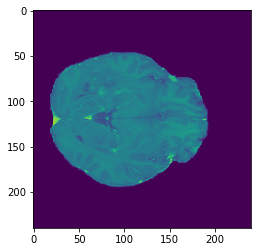

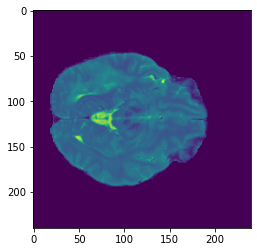

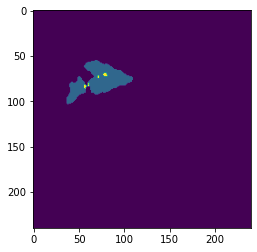

In [151]:
plt.imshow(x[0,:,:,60])
plt.show()
plt.imshow(x[1,:,:,60])
plt.show()
plt.imshow(seg[:,:,60])
plt.show()